# Inferring loads on an Euler Bernoulli beam

In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
matplotlib.rcParams['font.size'] = 16

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import random

# MUQ Includes
import pymuqModeling as mm
import pymuqApproximation as ma
import pymuqUtilities as mu

# Include the beam model
from BeamModel import EulerBernoulli

### Set up discretization

In [2]:
numPts = 201
dim = 1
x = np.linspace(0,1,numPts)[None,:]

## Set up the Beam model

In [3]:
# Array of modulus values
E = 1e5*np.ones(numPts)

# Geometry of beam (assumes beam is cylinder with constant cross sectional area)
length = 1.0
radius = 0.1

# Instance of the Beam class
beam = EulerBernoulli(numPts, length, radius, E)


## Generate synthetic data

In [4]:
numObs = 60
B = np.zeros((numObs,numPts))

obsInds = random.sample(range(numPts), numObs)
for i in range(numObs):
    B[i,obsInds[i]] = 1.0

obsMat = np.linalg.solve(beam.K,B.T).T

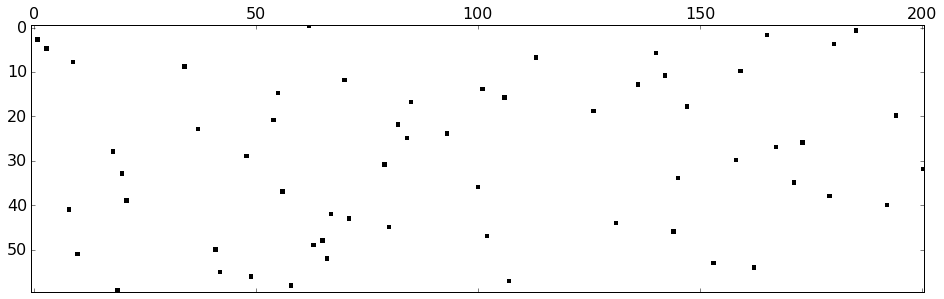

In [5]:
# Loads used to generate data
q = -9.81*np.ones(numPts)

# Additive noise parameters
noiseCov = 1e-12*np.eye(numObs)
epsilon = mm.Gaussian(np.zeros(numObs), noiseCov)

allDispl = beam.Evaluate([q])[0]

obsData = np.dot(obsMat,q) + epsilon.Sample()

plt.spy(B)
plt.show()

## Define the Gaussian Process prior

In [6]:
priorVar = 10*10
priorLength = 1.0
priorNu = 1.0/2.0 # must take the form N+1/2 for zero or odd N (i.e., {0,1,3,5,...})

kern = ma.MaternKernel(1, priorVar, priorLength, priorNu)
#kern = ma.ConstantKernel(1,priorVar)

dim =1
coDim = 1 # The dimension of the load field at a single point
mu = ma.ZeroMean(dim,coDim)

priorGP = ma.GaussianProcess(mu,kern)

### Plot prior samples

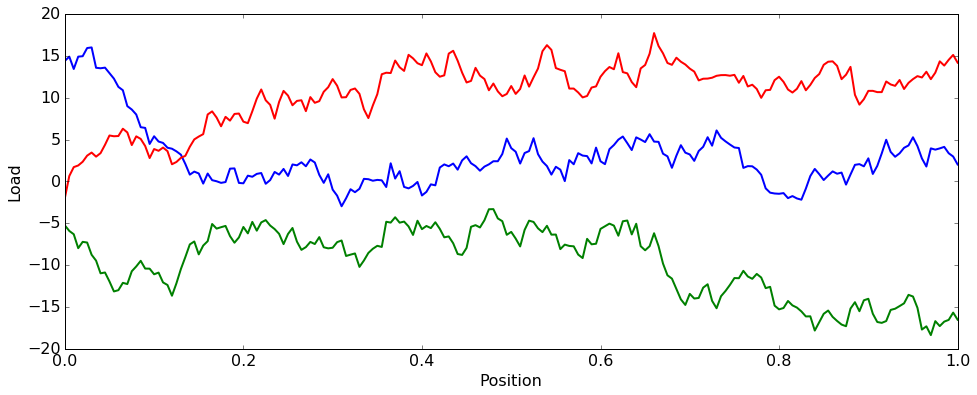

In [7]:
numSamps = 3
for i in range(numSamps):
    samp = priorGP.Sample(x)
    plt.plot(x[0,:], samp[0,:], linewidth=2)
    
plt.xlabel('Position')
plt.ylabel('Load')
plt.show()

### Compute posterior

In [8]:
prior = priorGP.Discretize(x)
post = prior.Condition(obsMat, obsData, noiseCov)

### Plot posterior

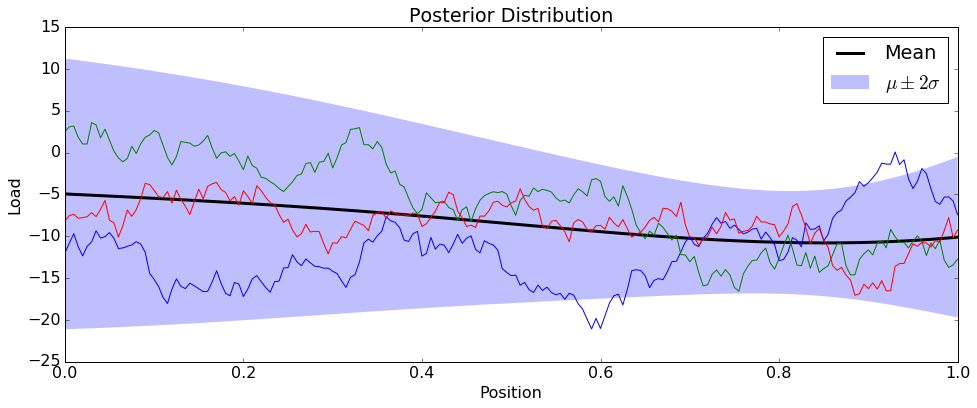

In [9]:
postMean = post.GetMean()
plt.plot(x.T, post.GetMean(), 'k', linewidth=3, label='Mean')

postCov = post.GetCovariance()
postStd = np.sqrt(np.diag(postCov))

plt.fill_between(x[0,:], postMean+2.0*postStd, postMean-2.0*postStd, alpha=0.25, edgecolor='None', label='$\mu \pm 2\sigma$')

for i in range(numSamps):
    samp = post.Sample()
    plt.plot(x.T, samp.T, linewidth=1)

plt.legend()
plt.title('Posterior Distribution')
plt.xlabel('Position')
plt.ylabel('Load')
plt.show()

## Analyze low-rank structure

The posterior precision is given by $\Gamma_{pos}^{-1} = H + \Gamma_{pr}^{-1}$, where $H$ is the Hessian of the log-likelihood function.  In this example, $H = A^T\Gamma_{obs}A$


In [10]:
import scipy.linalg as la

#### Rank of likelihood Hessian

In [11]:
likelyHess = np.dot( obsMat.T, la.solve(noiseCov, obsMat))

hessVals, _ = la.eigh(likelyHess)
hessVals[hessVals<1e-15] = 1e-15

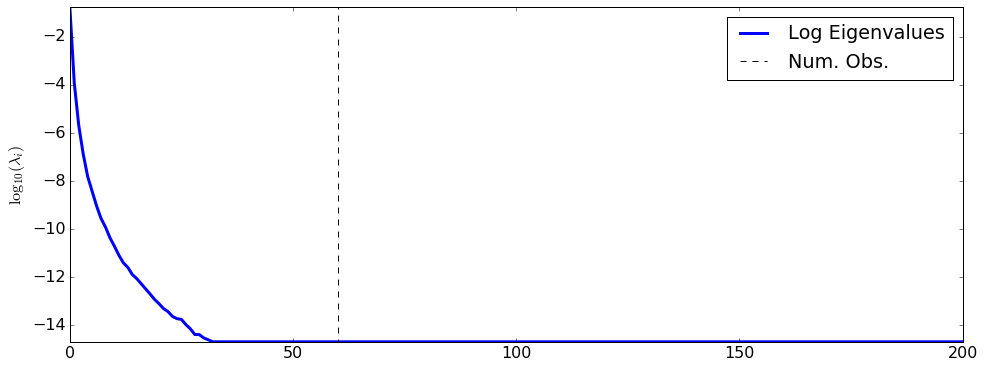

In [12]:
logHessVals = np.log10(hessVals+1e-15)
plt.plot(logHessVals[::-1], label='Log Eigenvalues', linewidth=3)
plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylabel('$\log_{10}(\lambda_i)$')

plt.ylim((np.min(logHessVals),np.max(logHessVals)))
plt.legend()

plt.show()

#### Likelihood-Informed Subspace

In [13]:
likelyHess = np.dot( obsMat.T, la.solve(noiseCov, obsMat))
priorPrec = prior.GetPrecision()
postPrec = priorPrec + likelyHess

priorVals, _ = la.eigh(priorPrec)
priorVals[priorVals<1e-15] = 1e-15

postVals, _ = la.eigh(postPrec)
postVals[postVals<1e-15] = 1e-15

lisVals, _ = la.eigh(likelyHess, priorPrec)
lisVals[lisVals<1e-15] = 1e-15

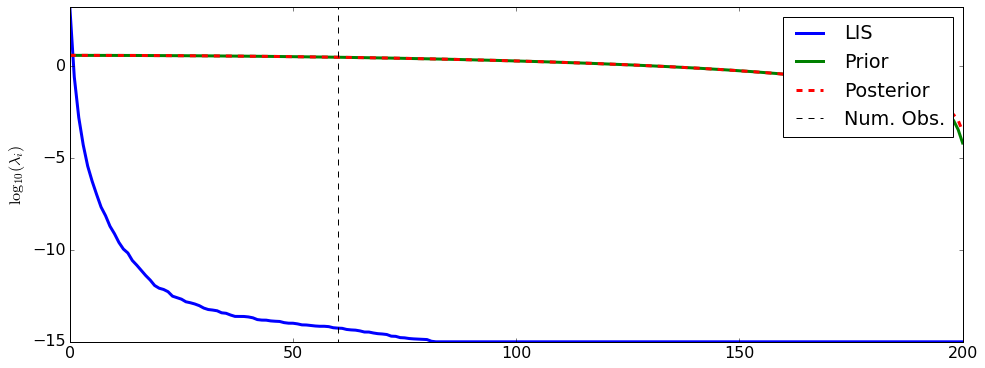

In [16]:
logLisVals = np.log10(lisVals)
plt.plot(logLisVals[::-1], label='LIS', linewidth=3)

logPriorVals = np.log10(priorVals)
plt.plot(logPriorVals[::-1], label='Prior', linewidth=3)

logPostVals = np.log10(postVals)
plt.plot(logPostVals[::-1], '--', label='Posterior', linewidth=3)

plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylabel('$\log_{10}(\lambda_i)$')

plt.ylim((np.min(logLisVals),np.max(logLisVals)))
plt.legend()
plt.show()